<a href="https://colab.research.google.com/github/jordantangy/MoviePosterClassification-CNN/blob/main/ConvNet_Movie_Poster_Classification_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0-rc0

     |████████████████████████████████| 86.3 MB 1.9 kB/s 
     |████████████████████████████████| 501 kB 72.4 MB/s 
     |████████████████████████████████| 4.3 MB 66.1 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 2.0.0rc0 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

##**Import dataset and show its content**

In [4]:
data = pd.read_csv('/content/drive/MyDrive/duplicate_free_41K.csv')
truncat = data[:30000]
truncat

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,short,thriller
0,0,https://m.media-amazon.com/images/M/MV5BNDM0ND...,Construction,2021,7.4,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,0
1,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,1,0
3,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,1,0
4,4,https://m.media-amazon.com/images/M/MV5BOGI0Nz...,Asalu Em Jarigindhante,2020,10.0,drama,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,30023,https://m.media-amazon.com/images/M/MV5BMTU1Nj...,A Mother's Nightmare,2012,6.0,"crime, mystery, thriller",0,0,0,0,1,0,0,0,1,0,0,0,1
29996,30024,https://m.media-amazon.com/images/M/MV5BMTQ3Mz...,SheZow,2012,6.0,"animation, action, adventure",1,1,1,0,0,0,0,0,0,0,0,0,0
29997,30025,https://m.media-amazon.com/images/M/MV5BNDNkN2...,The Seven Year Hitch,2012,6.0,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,0
29998,30026,https://m.media-amazon.com/images/M/MV5BNjg5ZD...,Onii-chan Dakedo Ai Sae Areba Kankei Nai yo ne-,2012,6.0,animation,0,0,1,0,0,0,0,0,0,0,0,0,0


In [5]:
!unzip /content/drive/MyDrive/img_41K.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: img_41K/5496.jpg        
  inflating: img_41K/5497.jpg        
  inflating: img_41K/5498.jpg        
  inflating: img_41K/5499.jpg        
  inflating: img_41K/55.jpg          
  inflating: img_41K/550.jpg         
  inflating: img_41K/5500.jpg        
  inflating: img_41K/5501.jpg        
  inflating: img_41K/5502.jpg        
  inflating: img_41K/5503.jpg        
  inflating: img_41K/5504.jpg        
  inflating: img_41K/5505.jpg        
  inflating: img_41K/5506.jpg        
  inflating: img_41K/5507.jpg        
  inflating: img_41K/5508.jpg        
  inflating: img_41K/5509.jpg        
  inflating: img_41K/551.jpg         
  inflating: img_41K/5510.jpg        
  inflating: img_41K/5511.jpg        
  inflating: img_41K/5512.jpg        
  inflating: img_41K/5513.jpg        
  inflating: img_41K/5514.jpg        
  inflating: img_41K/5515.jpg        
  inflating: img_41K/5516.jpg        
  inflatin

##**Insertion of the pictures into a managable array**

In [6]:
pic_width = 224
pic_height = 224
X_train = []
X_test = []
X_val = []
for i in tqdm(range(int(truncat.shape[0]))):
  if i < int(truncat.shape[0]*0.60)-1 :
    path = '/content/img_41K/'+ str(data['id'][i]) +'.jpg'
    img = image.load_img(path, target_size=(pic_width,pic_height,3))
    img = image.img_to_array(img)
    img = img/255.0
    X_train.append(img)
  elif i > int(truncat.shape[0]*0.60)-1 and i < int(truncat.shape[0]*0.8)-1 :
    path = '/content/img_41K/'+ str(data['id'][i]) +'.jpg'
    img = image.load_img(path, target_size=(pic_width,pic_height,3))
    img = image.img_to_array(img)
    img = img/255.0
    X_test.append(img)
  else :
    path = '/content/img_41K/'+ str(data['id'][i]) +'.jpg'
    img = image.load_img(path, target_size=(pic_width,pic_height,3))
    img = image.img_to_array(img)
    img = img/255.0
    X_val.append(img)

100%|██████████| 30000/30000 [01:36<00:00, 309.51it/s]


In [7]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

##**Example of a poster from the DataSet and its corresponding genre**

'comedy, sci-fi, thriller'

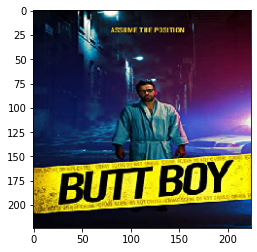

In [8]:
plt.imshow(X_train[5475])
data['genre'][5475]

In [9]:
#matrix y comes from the csv file, we just drop the column id and genre.
#So we have a matrix representing which genre each movie belongs to

y = truncat.drop(['id','poster','title','year','rating','genre'], axis = 1)
y = y.to_numpy()
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

##**Splitting the dataset into train set and test set**

In [10]:
train_size = int(X_train.shape[0])
test_size = int(X_test.shape[0])

In [11]:
y_train = []
y_test = []
y_val = []
for i in range(train_size):
  y_train.append(y[i])
y_train = np.array(y_train)

for i in range(train_size,train_size+test_size):
  y_test.append(y[i])
y_test = np.array(y_test)

for i in range(train_size+test_size,30000):
  y_val.append(y[i])
y_val = np.array(y_val)

##**Building the CNN Model**

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())



model.add(Dense(13, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0

##**Compilation**

In [13]:
model.compile(optimizer="adam", loss = 'binary_crossentropy', metrics=['accuracy'])

##**Start training**

In [14]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val) , callbacks=[callback],batch_size= 100)

Train on 17999 samples, validate on 6002 samples
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
17999/17999 [==============================] - 203s 11ms/sample - loss: 0.5409 - accuracy: 0.7478 - val_loss: 0.8359 - val_accuracy: 0.7909
Epoch 2/20
17999/17999 [==============================] - 202s 11ms/sample - loss: 0.3881 - accuracy: 0.8401 - val_loss: 0.6196 - val_accuracy: 0.7902
Epoch 3/20
17999/17999 [==============================] - 204s 11ms/sample - loss: 0.3729 - accuracy: 0.8451 - val_loss: 0.4431 - val_accuracy: 0.8125
Epoch 4/20
17999/17999 [==============================] - 202s 11ms/sample - loss: 0.3524 - accuracy: 0.8524 - val_loss: 0.4230 - val_accuracy: 0.8221
Epoch 5/20
17999/17999 [==============================] - 201s 11ms/sample - loss: 0.3219 - accuracy: 0.8646 - val_loss: 0.4672 - val_accuracy: 0.8128


##**Plot the values obtained during the training session**

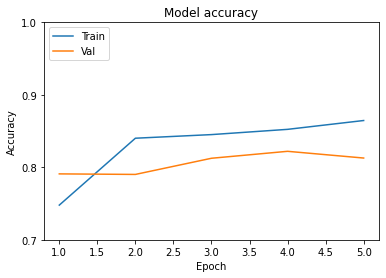

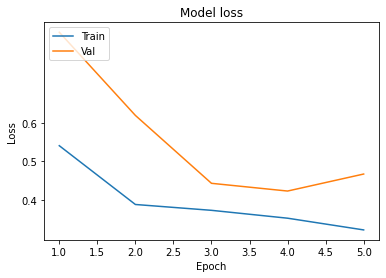

In [17]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.yticks([0.7,0.8,0.9,1])
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.yticks([0.4,0.5,0.6])
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, 5)

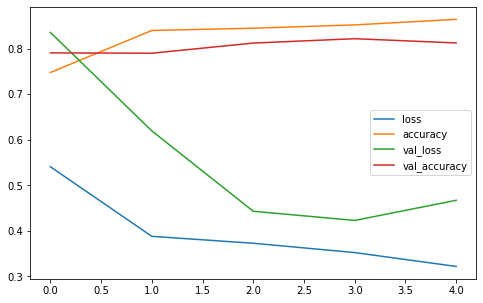

In [27]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

##**Evaluating the model**

In [28]:
#Testing the model on the test set

ev = model.evaluate(X_test,y_test)

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [29]:
loss = str(int(round(ev[0],2)*100))+'%'
accuracy = str(int(round(ev[1],2)*100))+'%'
print("Testing the model on 6000 samples gives a loss of ", loss , " and an accuracy of ",accuracy)

Testing the model on 6000 samples gives a loss of  66%  and an accuracy of  77%


##**A few examples of testing**

In [ ]:
img = image.load_img('/content/8effb44395f86988a83259473102fc2e6cdc43def49da9bfa3ac600d04708c63._RI_V_TTW_.jpg', target_size=(pic_width,pic_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1, pic_width, pic_height, 3)

genres = data.columns[6:]
y_prob = model.predict(img)
arr = np.array(y_prob)
top2 = np.argsort(y_prob[0])
print("The 2 genres predicted for the Movie Poster 'Nightmare' are :")
for i in range(11,13):
  index = top2[i]
  print(genres[index])
print("The expected output was at least 'horror', hence the network succeeded")

In [ ]:
img = image.load_img('/content/action_poster.jpg', target_size=(pic_width,pic_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1, pic_width, pic_height, 3)

genres = data.columns[6:]
y_prob = model.predict(img)
arr = np.array(y_prob)
top2 = np.argsort(y_prob[0])
print("The 2 genres predicted for the Movie Poster 'War' are :")
for i in range(11,13):
  index = top2[i]
  print(genres[index])
print("The expected output was at least 'action', hence the network succeeded")

In [ ]:
img = image.load_img('/content/love-romance-chocolate-movie-poster-md.jpg', target_size=(pic_width,pic_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1, pic_width, pic_height, 3)

genres = data.columns[6:]
y_prob = model.predict(img)
arr = np.array(y_prob)
top2 = np.argsort(y_prob[0])
print("The 2 genres predicted for the Movie Poster 'Love, Romance and Chocolate' are :")
for i in range(11,13):
  index = top2[i]
  print(genres[index])
print("The expected output was at least 'romance', hence the network succeeded")

In [ ]:
img = image.load_img('/content/sci-fi-fantasy_0017_ebay_listing.jpg', target_size=(pic_width,pic_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1, pic_width, pic_height, 3)

genres = data.columns[6:]
y_prob = model.predict(img)
arr = np.array(y_prob)
top2 = np.argsort(y_prob[0])
print("The 2 genres predicted for the Movie Poster 'Avatar' are :")
for i in range(11,13):
  index = top2[i]
  print(genres[index])
print("The expected output was at least 'sci-fi', but it doesn't appear, hence the network didn't succeed to predict the right genre")